In [1]:
%load_ext autoreload
%autoreload 2
import sys
import collections
import numpy as np
# sys.path.append("/private/home/alexandrerame/domainbedv2/")
# sys.path.append("/private/home/alexandrerame/slurmconfig/notebook/data")

sys.path.append("/home/rame/domainbedv2/")

from domainbed.codeplot import plot

In [2]:
plot.plt.rcParams["figure.figsize"] = (6, 6)
# plot.plt.rcParams['text.usetex'] = True
# plot.plt.rcParams['font.family'] = 'serif'
# plot.plt.rcParams['font.serif'] = 'Times Roman'
# plot.FORMAT_X = 1
# plot.FORMAT_Y = 3
plot.dict_key_to_label.update(
    {
        "ROUGE_L": "rouge score",
        "Bleu_1": "bleu score",
        "Bleu_4": "bleu4 score",
        "METEOR": "meteor score"
    }
)


# fts

In [3]:
from notebooks.data.captioning import fts_bleu4, fts_bleu, fts_rouge, fts_meteor, fts_bleurouge, fts_bleumeteor

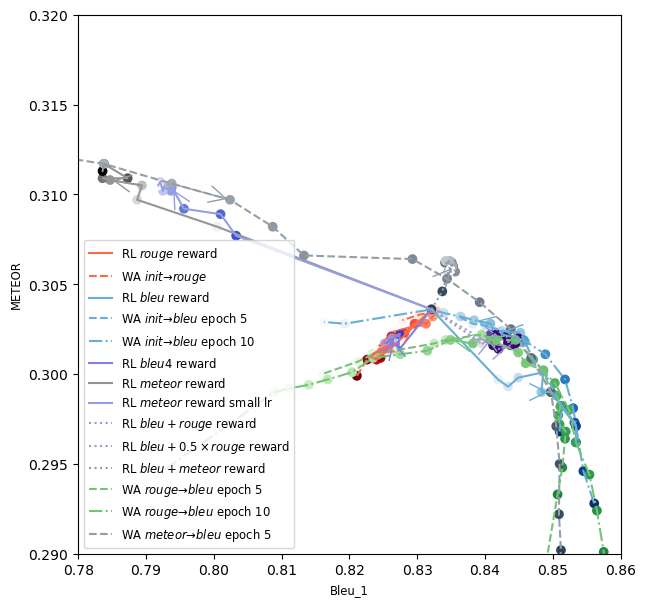

In [38]:
plot.plt.rcParams["figure.figsize"] = (7, 7)
plot.SIZE_AXIS = "small"
plot.SIZE = "small"
fig_dr = plot.plot_key(
    [
        fts_rouge.l_step,
        fts_rouge.l_wa_step5,
        fts_bleu.l_step,
        fts_bleu.l_wa_step5,
        fts_bleu.l_wa,
        fts_bleu4.l_step,
        fts_meteor.l_step,
        fts_meteor.l_steplr,
        fts_bleurouge.l_step,
        fts_bleurouge.l_step_15,
        fts_bleumeteor.l_step,
        fts_bleurouge.l_wa_epoch5,
        fts_bleurouge.l_wa_epoch10,
        fts_bleumeteor.l_wa,
    ],
    # list_indexes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    key_x="Bleu_1",
    key_y="METEOR",
    labels=[
        r"RL $rouge$ reward",
        r"WA $init \to rouge$",
        r"RL $bleu$ reward",
        r"WA $init \to bleu$ epoch 5",
        r"WA $init \to bleu$ epoch 10",
        r"RL $bleu4$ reward",
        r"RL $meteor$ reward",
        r"RL $meteor$ reward small lr",
        r"RL $bleu+rouge$ reward",
        r"RL $bleu+0.5 \times rouge$ reward",
        r"RL $bleu+meteor$ reward",
        r"WA $rouge \to bleu$ epoch 5",
        r"WA $rouge \to bleu$ epoch 10",
        r"WA $meteor \to bleu$ epoch 5",
    ],
    loc="best",
    keycolor="lambda",
    colormaps=[
        "Reds",
        "Reds",
        "Blues",
        "Blues",
        "Blues",
        "Dark_Blues",
        "Greys",
        "Dark_Greys",
        "Purples",
        "Purples",
        "Blues_Greys",
        'Greens',
        "Greens",
        "Blues_Greys",
    ],
    linestyles=[
        ls if ls not in [] else None for ls in [
            "solid", "dashed", "solid", "dashed", "dashdot", "solid", "solid", "solid", "dotted",
            "dotted", "dotted", 'dashed', "dashdot", "dashed"
        ]
    ],
    connect_points=True,
    order=2,
    _dict_key_to_limit={
        "Bleu_1": [0.78, 0.86],
        "ROUGE_L": [0.60, 0.612],
        "METEOR": [0.29, 0.32]
    },
)

# e2e

In [ ]:
from notebooks.data.captioning import e2e_bleu, e2e_bleu4, e2e_rouge, e2e_bleurouge, e2e_bleu4rouge, e2e_meteor, e2e_bleubleu4

In [ ]:
fig_dr = plot.plot_basic_scatter(
    e2e_bleu.l_wa,  #, l_ens],
    key_x="lambda",
    keys_y=["ROUGE_L", "Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4", "CIDEr", "METEOR", "SPICE"],
    loc="best",
    _dict_key_to_label={},
)

In [ ]:
fig_dr = plot.plot_key(
    [
        fts_bleu.l_step,
        e2e_bleu.l_step,
        e2e_bleu.l_wa,
        e2e_bleu.l_wableubleu,
    ],
    key_x="Bleu_1",
    key_y="CIDEr",
    labels=[
        r"fts: cider $\to$ bleu",
        r"e2e: cider $\to$ bleu",
        r"wa: cider $\to$ bleu",
        r"wa: epoch4 $\to$ epoch1",
    ],
    loc="best",
    keycolor="lambda",
    colormaps=[
        "Blues",
        'Purples',
        'Blues',
        'Blues',
    ],
    linestyles=["solid", 'solid', 'dashed', 'dotted'],
    connect_points=True
)

In [ ]:
fig_dr = plot.plot_key(
    [
        e2e_bleu.l_step, e2e_bleu.l_wa, e2e_bleu.l_wableubleu, e2e_bleu4.l_step, e2e_bleu4.l_wa,
        e2e_bleubleu4.l_step, e2e_bleubleu4.l_wa_bleu4bleu
    ],
    key_x="Bleu_1",
    key_y="Bleu_4",
    labels=[
        r"RL $bleu$ reward", r"WA $cider \to bleu$",
        r"WA $bleu$ epoch 1 $\to$ $bleu$ epoch 4",
        r"RL $bleu4$ reward", r"WA $cider \to bleu4$",
        r"RL $\frac{bleu+bleu4}{2}$ reward",
        r"WA $bleu \to bleu4$"
    ],
    loc="best",
    keycolor="lambda",
    colormaps=['Blues', 'Blues', 'Blues', 'Reds', 'Reds', "Purples", 'Greens'],
    linestyles=['solid', 'dashed', 'dashdot', 'solid', 'dashed', "solid", 'dashdot'],
    connect_points=True
)

In [ ]:


fig_dr = plot.plot_key(
    [
        e2e_bleu.l_step, e2e_rouge.l_step, e2e_bleurouge.l_step_rougebleu,
        e2e_bleurouge.l_wa_rougebleu
    ],
    key_x="Bleu_1",
    key_y="ROUGE_L",
    labels=[
        r"RL $bleu$ reward", r"RL $rouge$ reward",
        r"RL $\frac{bleu+rouge}{2}$ reward",
        r"WA $bleu$ $\to$ $rouge$"
    ],
    loc="best",
    keycolor="lambda",
    colormaps=['Blues', 'Reds', "Purples", 'Greens'],
    linestyles=['solid', 'solid', "solid", 'dashed'],
    _dict_key_to_limit={
        "Bleu_1": [0.815, 0.86],
        "ROUGE_L": [0.597, 0.610]
    },
    connect_points=True
)
plot.plt.annotate("Pre-trained init", xy=(0.826, 0.606))
plot.plt.annotate(r"$rouge$ ft", xy=(0.815, 0.6078), color="red")
plot.plt.annotate(r"$bleu$ ft", xy=(0.854, 0.5975), color="blue")
plot.plt.annotate(r"$\frac{bleu+rouge}{2}$ ft", xy=(0.8378, 0.6088), color="purple")

In [ ]:
fig_dr = plot.plot_key(
    [
        e2e_bleu.l_step, e2e_bleu.l_wa,
        e2e_rouge.l_step, e2e_rouge.l_steplr, e2e_rouge.l_wa,
        e2e_bleurouge.l_step_rougebleu,
        e2e_bleurouge.l_wa_rougebleu
    ],
    key_x="Bleu_1",
    key_y="ROUGE_L",
    labels=[
        r"ft: cider $\to$ bleu",
        r"wa: cider $\to$ bleu",
        r"ft: cider $\to$ rouge",
        r"ftlr: cider $\to$ rouge",
        r"wa: cider $\to$ rouge",
        r"ft: cider $\to$ bleu+rouge",
        r"wa: bleu $\to$ rouge"
    ],
    loc="best",
    keycolor="lambda",
    colormaps=['Blues', 'Blues', 'Reds', 'Purples', 'Reds', 'Greens', 'Greens'],
    linestyles=['solid', 'dashed', 'solid', 'solid', 'dashed', "solid", 'dotted'],
    connect_points=True
)

In [ ]:
plot.plt.rcParams["figure.figsize"] = (6, 6)
fig_dr = plot.plot_key(
    [
        e2e_bleu4.l_step, e2e_bleu4.l_steplr, e2e_bleu4.l_wa, e2e_rouge.l_step, e2e_rouge.l_wa,
        e2e_bleu4rouge.l_step,
        e2e_bleu4rouge.l_wa_rougebleu4
    ],
    key_x="Bleu_4",
    key_y="ROUGE_L",
    labels=[
        r"RL $bleu4$ reward",
        r"RL $bleu4$ reward lr",
        r"WA $cider \to bleu4$",
        r"RL $rouge$ reward", r"WA $cider \to rouge$",
        r"RL $\frac{bleu4+rouge}{2}$ reward",
        r"WA $bleu4 \to rouge$"
    ],
    loc="best",
    keycolor="lambda",
    colormaps=['Blues', 'Blues', 'Blues', 'Reds', 'Reds', "Purples", 'Greens'],
    linestyles=['solid', 'solid', 'dashed', 'solid', 'dashed', "solid", 'dashdot'],
    connect_points=True
)